<a href="https://colab.research.google.com/github/aditijoshi613/Consumer-Price-Index-Prediction/blob/main/Code_DATA602_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Extraction

In [ ]:
!pip install fredapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fredapi import Fred
import numpy as np
from numpy import nan
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fred = Fred(api_key='3aa0889a9d5c342d2e52a4c137e168fb')
series1 = fred.get_series_latest_release('CPALTT01USM657N')
df = pd.DataFrame({'timestamp':series1.index,'CPI':series1.values})
df = df.set_index(['timestamp'])
df = df.loc['1960-01-01':]
print("Size of Dataset is", df.shape)
df.head()

Size of Dataset is (753, 1)


,CPI
timestamp,
1960-01-01,-0.340136
1960-02-01,0.341297
1960-03-01,0.000000
1960-04-01,0.340136
1960-05-01,0.000000


# Exploratory Data Analysis

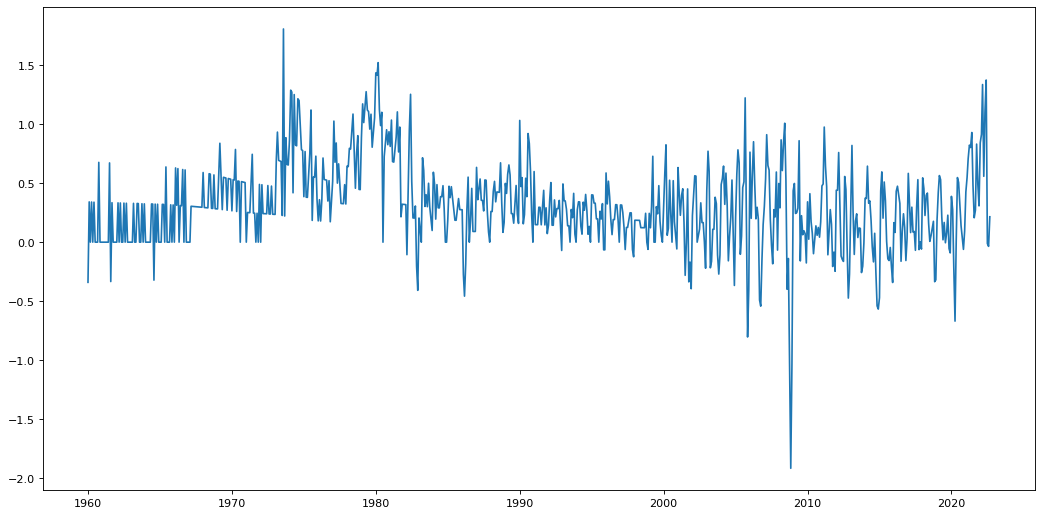

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)
plt.plot(df.index,df.CPI)

### Outlier Detection

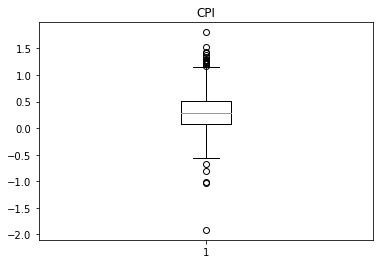

In [ ]:
def box_plot(df,i):
  plt.boxplot(df.iloc[:,i])
  plt.title(df.columns.values.tolist()[i])
  plt.show()
box_plot(df,0)

### Outlier Removal

In [ ]:
q1 = np.percentile(df['CPI'],25)
q3 = np.percentile(df['CPI'],75)
boolean_condition = (df['CPI'] < q1 - (q3-q1)*1.3) | (df['CPI'] > q3 + (q3-q1)*1.3)
column_name = 'CPI'
new_value = np.mean(df['CPI'])

df.loc[boolean_condition, column_name] = new_value
df.head()

,CPI
timestamp,
1960-01-01,-0.340136
1960-02-01,0.341297
1960-03-01,0.000000
1960-04-01,0.340136
1960-05-01,0.000000


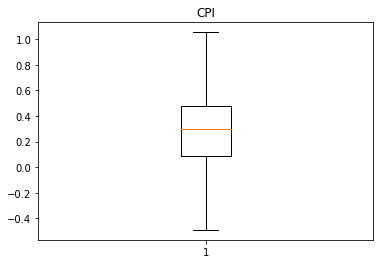

In [ ]:
box_plot(df,0)

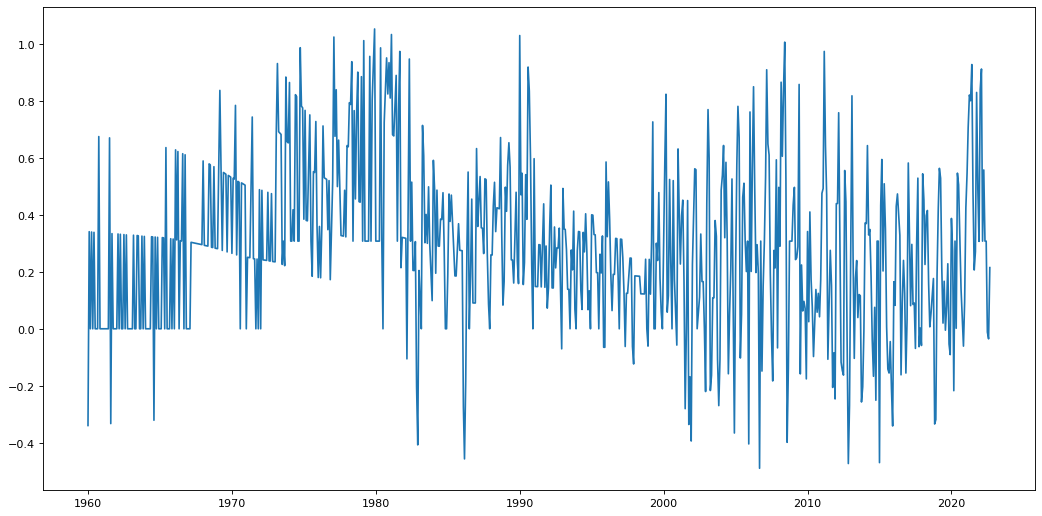

In [ ]:
figure(figsize=(16, 8), dpi=80)
plt.plot(df.index,df.CPI)

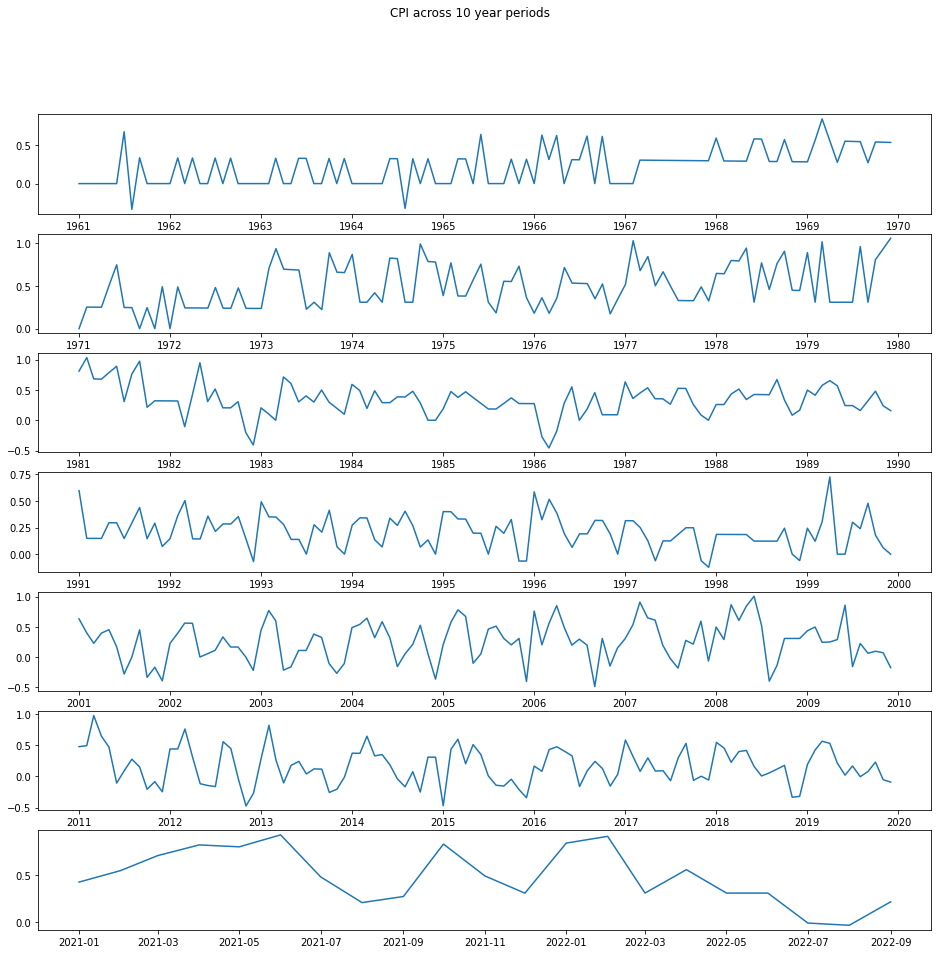

In [ ]:
from pandas.tseries.offsets import YearEnd
plt.rc("figure",figsize=(16,15))
year = df.index.year.min()

fig, axs = plt.subplots((df.index.year.max() - df.index.year.min())//10 + 1)
fig.suptitle('CPI across 10 year periods')
count = 0

while year in df.index.year:
  df_temp = df[(df.index.year > year) & (df.index.year < year+10)]
  axs[count].plot(df_temp.index,df_temp.CPI)
  year = year + 10
  count = count + 1

### Decomposition

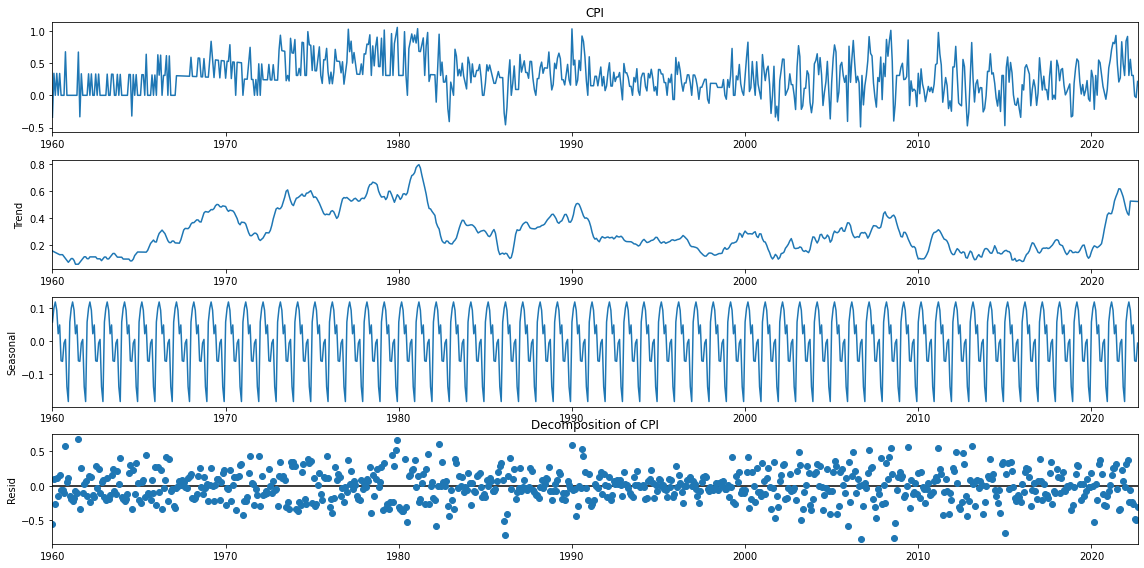

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc("figure",figsize=(16,8))

def decompose(df, i):
  series = df.iloc[:,i]
  result = seasonal_decompose(series, model='additive',extrapolate_trend='freq',period=12)
  result.plot()
  plt.title('Decomposition of '+ df.columns.values.tolist()[i])
  plt.show()
  return result
result = decompose(df, 0)

## Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

def ADF_Test(df,df_adf,i):	
	series = df.iloc[:,i]
	X = series.values
	result = adfuller(X)
	df_adf_i = pd.DataFrame({'Output':df.columns.values.tolist()[i],'ADF Statistic':result[0],'p-value':result[1],'CriticalValues':result[4]})
	df_adf = df_adf.append(df_adf_i,ignore_index = True)
	return df_adf

In [ ]:
df_adf = pd.DataFrame()
df_adf = ADF_Test(df,df_adf,0)
df_adf

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-3.248284,0.017354,-3.439206
1,CPI,-3.248284,0.017354,-2.568851
2,CPI,-3.248284,0.017354,-2.865448


### Removing seasonality to make data stationary 

In [ ]:
df_nonseasonal = pd.DataFrame()
df_nonseasonal['CPI'] = df['CPI'] - df.shift(12).replace(nan,0)['CPI'] #- result.seasonal
df_nonseasonal.head()

,CPI
timestamp,
1960-01-01,-0.340136
1960-02-01,0.341297
1960-03-01,0.000000
1960-04-01,0.340136
1960-05-01,0.000000


In [ ]:
df_adf = pd.DataFrame()
df_adf = ADF_Test(df_nonseasonal,df_adf,0)
df_adf

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-9.628291,1.638032e-16,-3.439218
1,CPI,-9.628291,1.638032e-16,-2.568854
2,CPI,-9.628291,1.638032e-16,-2.865454


### Subtracting Lags to make data stationary

In [ ]:
df_nonseasonal['lag1'] = df_nonseasonal['CPI'] - df_nonseasonal.shift(1).replace(nan,0)['CPI']
df_nonseasonal.head()

,CPI,lag1
timestamp,,
1960-01-01,-0.340136,-0.340136
1960-02-01,0.341297,0.681433
1960-03-01,0.000000,-0.341297
1960-04-01,0.340136,0.340136
1960-05-01,0.000000,-0.340136


In [ ]:
df_adf = pd.DataFrame()
df_adf = ADF_Test(pd.DataFrame(df_nonseasonal['lag1']),df_adf,0)
df_adf

,Output,ADF Statistic,p-value,CriticalValues
0,lag1,-10.630571,5.227415e-19,-3.439303
1,lag1,-10.630571,5.227415e-19,-2.568874
2,lag1,-10.630571,5.227415e-19,-2.865491


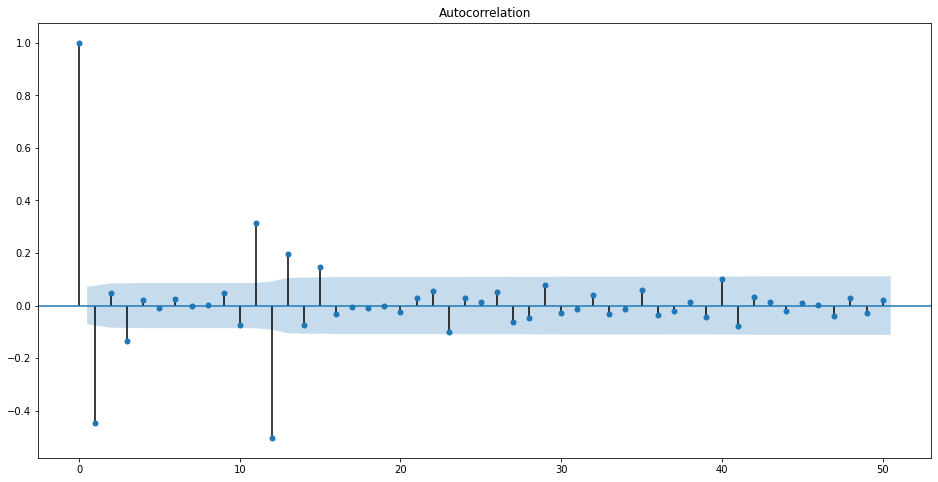

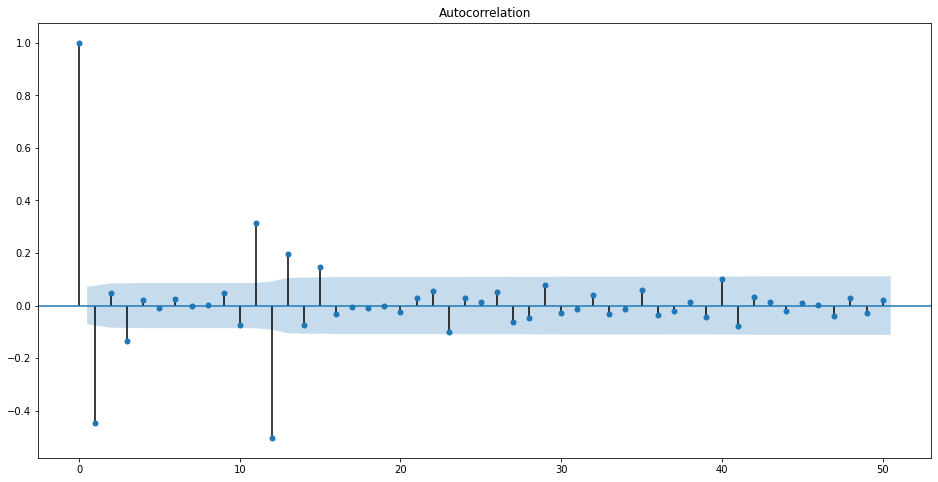

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_nonseasonal['lag1'],lags = 50)

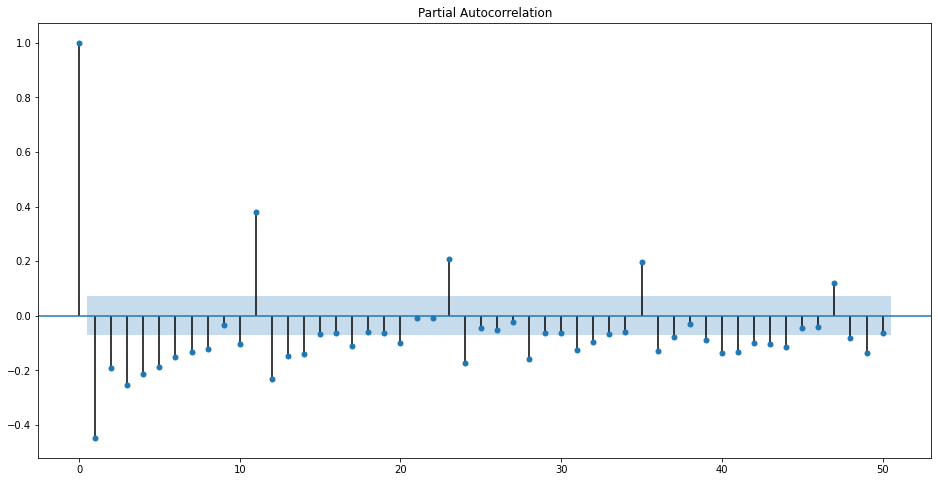

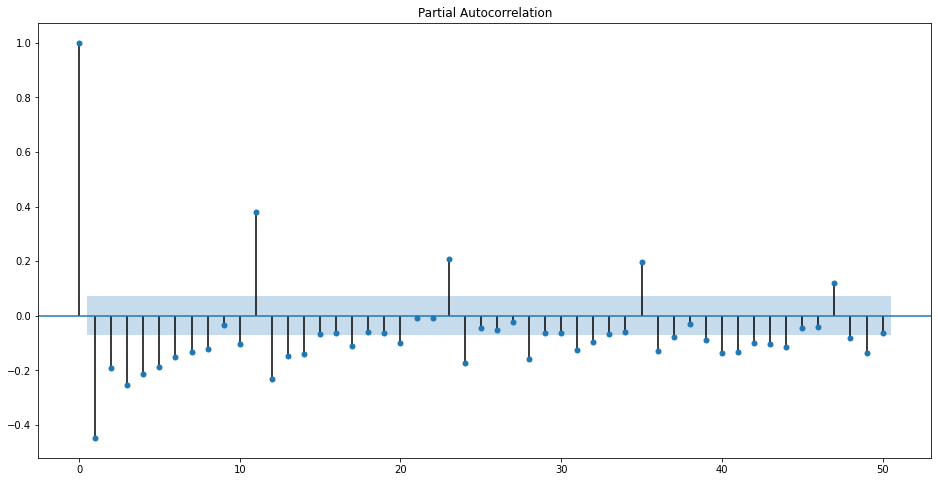

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_nonseasonal['lag1'],lags = 50)

### SARIMA model

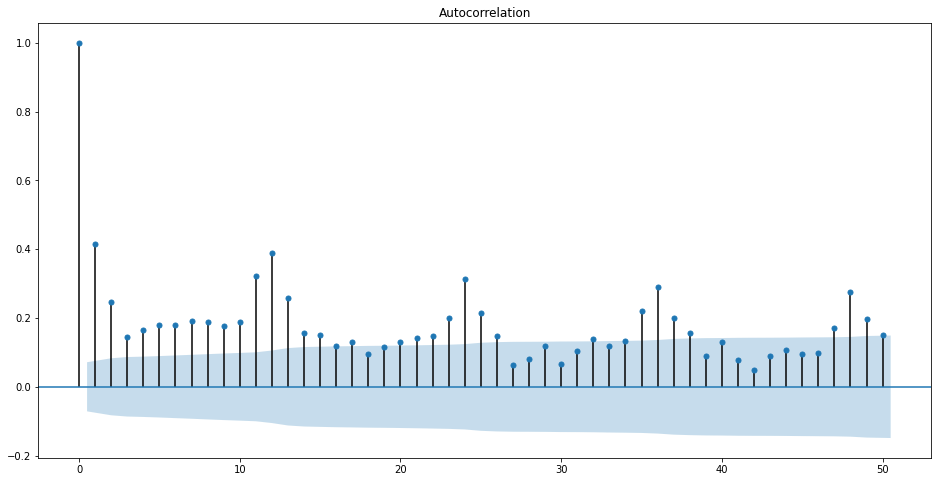

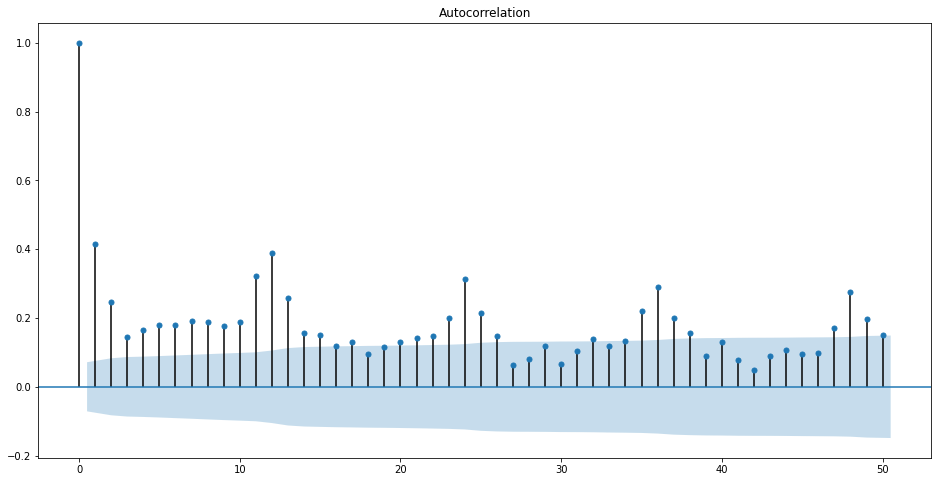

In [ ]:
#autocorrelation plots for original data
plot_acf(df['CPI'],lags = 50)

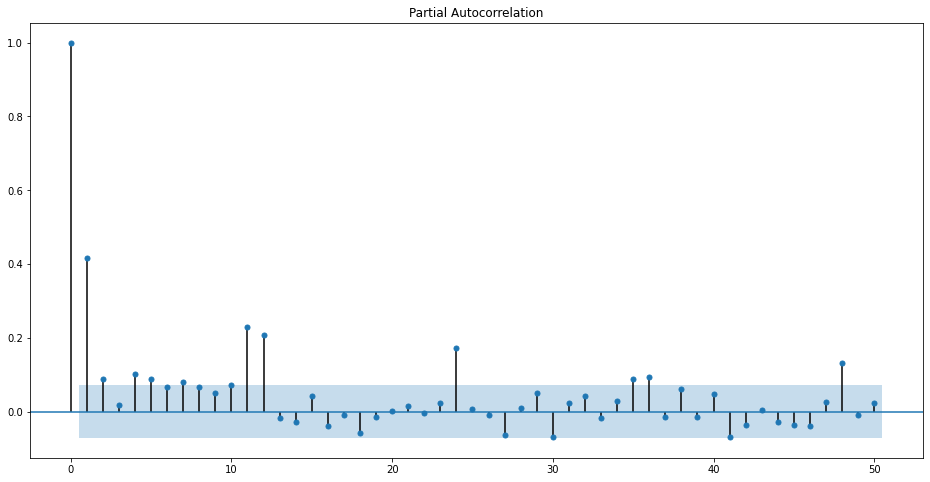

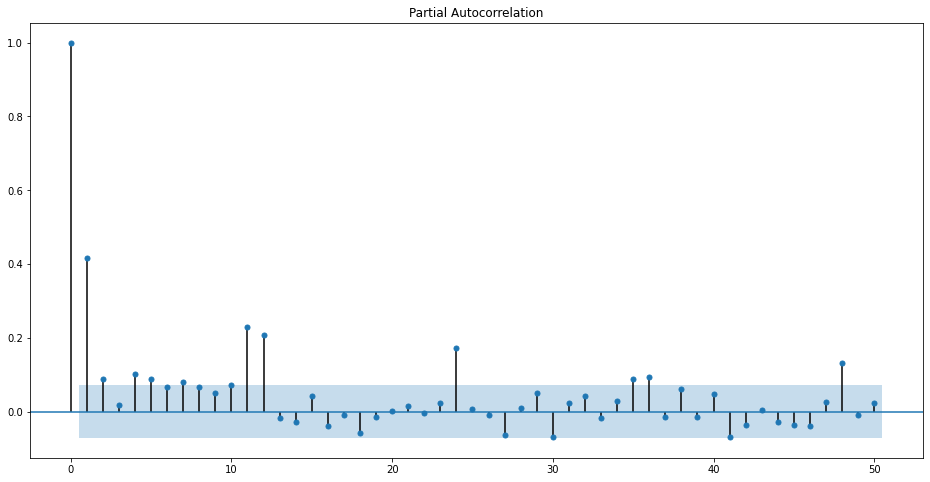

In [ ]:
plot_pacf(df['CPI'],lags = 50)

## Train-Test Split

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_train = df.iloc[:int(0.9*df.shape[0]),:]
SARIMA_test = df.iloc[int(0.9*df.shape[0]):,:]

#### Model

In [ ]:
my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

SARIMA_model = SARIMAX(SARIMA_train, order=my_order, seasonal_order=my_seasonal_order)

SARIMA_model_fit = SARIMA_model.fit()
print(SARIMA_model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                  677
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  -6.392
Date:                            Tue, 13 Dec 2022   AIC                             18.784
Time:                                    00:27:34   BIC                             32.279
Sample:                                01-01-1960   HQIC                            24.014
                                     - 05-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9006      0.014    -64.093      0.000      -0.928      -0.873
ma.S.L12      -0.8670      0.022   

# Predictions

## Predictions for training data

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


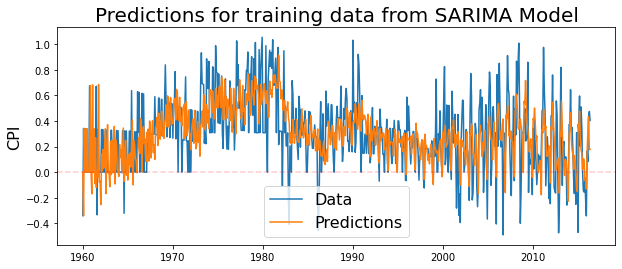

In [ ]:
SARIMA_predictions = SARIMA_model_fit.predict(start = SARIMA_train.index[0], end = SARIMA_train.index[-1])
plt.figure(figsize=(10,4))
plt.plot(SARIMA_train)
plt.plot(SARIMA_predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Predictions for training data from SARIMA Model', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

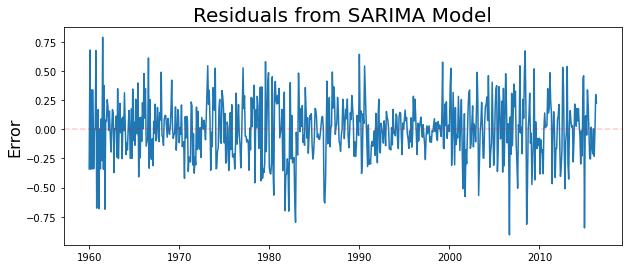

In [ ]:
SARIMA_residuals = SARIMA_train['CPI'] - pd.DataFrame(SARIMA_predictions)['predicted_mean']
plt.figure(figsize=(10,4))
plt.plot(SARIMA_residuals)
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Error:', round(np.mean(abs(SARIMA_residuals)),4))
print('\nRoot Mean Squared Error:', np.sqrt(np.mean(SARIMA_residuals**2)))

Mean Absolute Error: 0.192

Root Mean Squared Error: 0.24926098224090365


### Residual Analysis

In [ ]:
#residuals analysis
residuals = [SARIMA_train.iloc[i,:]-SARIMA_predictions[i] for i in
range(len(SARIMA_predictions))]
residuals = pd.DataFrame(residuals)
residuals.head()

,CPI
1960-01-01,-0.340136
1960-02-01,0.681433
1960-03-01,-0.341297
1960-04-01,0.340136
1960-05-01,-0.340136


In [ ]:
residuals.describe()

,CPI
count,677.000000
mean,-0.003694
std,0.249418
min,-0.905958
25%,-0.153833
50%,0.000910
75%,0.154933
max,0.790660


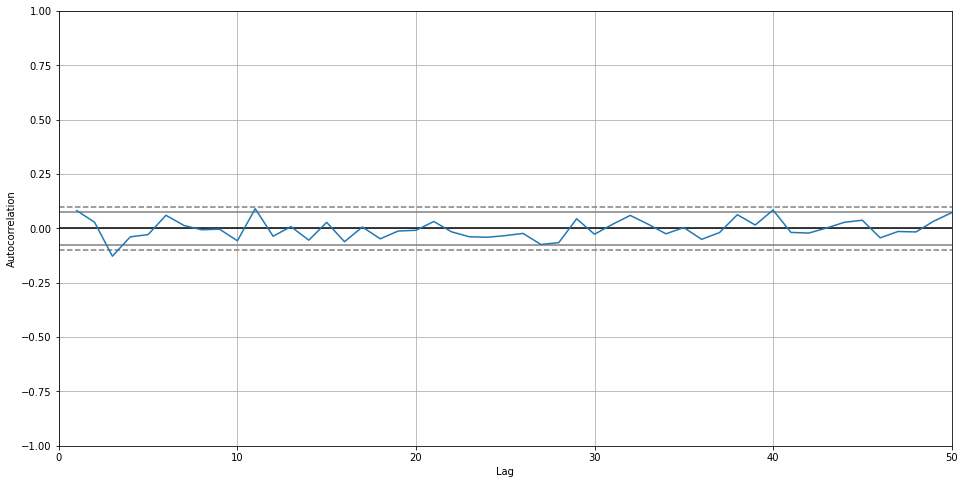

In [ ]:
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(np.array(residuals))
ax.set_xlim([0, 50])
plt.show()

In [ ]:
df_adf = pd.DataFrame()
df_adf = ADF_Test(residuals,df_adf,0)
df_adf
#residuals are white noise, hence, the model has captured the collinearity well.

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-16.325375,3.098340e-29,-3.440089
1,CPI,-16.325375,3.098340e-29,-2.569059
2,CPI,-16.325375,3.098340e-29,-2.865838


## Predictions on test data

In [ ]:
SARIMA_predictions_test = SARIMA_model_fit.predict(start = SARIMA_test.index[0], end = SARIMA_test.index[-1])
SARIMA_residuals_test = SARIMA_test['CPI'] - pd.DataFrame(SARIMA_predictions_test)['predicted_mean']

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Text(0, 0.5, 'CPI')

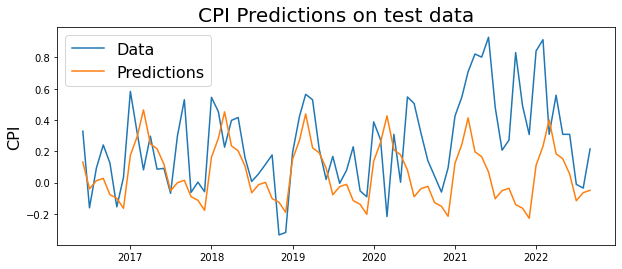

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(SARIMA_test)
plt.plot(SARIMA_predictions_test)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('CPI Predictions on test data', fontsize=20)
plt.ylabel('CPI', fontsize=16)

In [ ]:
print('Mean Absolute Error:', round(np.mean(abs(SARIMA_residuals_test)),4))
print('\nRoot Mean Squared Error:', np.sqrt(np.mean(SARIMA_residuals_test**2)))

Mean Absolute Error: 0.2533

Root Mean Squared Error: 0.33229205662944356


### Rolling Forecast Origin

In [ ]:
from pandas.core.groupby.groupby import Timestamp
from dateutil.relativedelta import relativedelta
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

start_time = datetime(1960,1,1)
end_time = datetime(2016,6,1)

In [ ]:
my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

roll_end_time = end_time
SARIMA_roll_train = df.loc[start_time:end_time]

while roll_end_time+relativedelta(months=+1) in df.index:
  
  SARIMA_roll_test = df.loc[roll_end_time:roll_end_time+relativedelta(months=+0)]
  SARIMA_roll_model = SARIMAX(SARIMA_roll_train, order=my_order, seasonal_order=my_seasonal_order)
  SARIMA_roll_model_fit = SARIMA_roll_model.fit()
  SARIMA_roll_predictions = SARIMA_roll_model_fit.predict(start = SARIMA_roll_test.index[0], end = SARIMA_roll_test.index[-1])

  print(roll_end_time)
  roll_end_time = roll_end_time + relativedelta(months=+1)
  SARIMA_roll_train.loc[roll_end_time] = float(SARIMA_roll_predictions)

2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00
2016-12-01 00:00:00
2017-01-01 00:00:00
2017-02-01 00:00:00
2017-03-01 00:00:00
2017-04-01 00:00:00
2017-05-01 00:00:00
2017-06-01 00:00:00
2017-07-01 00:00:00
2017-08-01 00:00:00
2017-09-01 00:00:00
2017-10-01 00:00:00
2017-11-01 00:00:00
2017-12-01 00:00:00
2018-01-01 00:00:00
2018-02-01 00:00:00
2018-03-01 00:00:00
2018-04-01 00:00:00
2018-05-01 00:00:00
2018-06-01 00:00:00
2018-07-01 00:00:00
2018-08-01 00:00:00
2018-09-01 00:00:00
2018-10-01 00:00:00
2018-11-01 00:00:00
2018-12-01 00:00:00
2019-01-01 00:00:00
2019-02-01 00:00:00
2019-03-01 00:00:00
2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-01 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-01 00:00:00
2019-10-01 00:00:00
2019-11-01 00:00:00
2019-12-01 00:00:00
2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00


Text(0, 0.5, 'CPI')

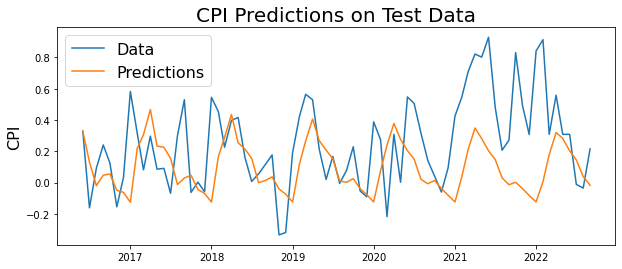

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(df.loc[end_time:])
plt.plot(SARIMA_roll_train.loc[end_time:])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('CPI Predictions on Test Data', fontsize=20)
plt.ylabel('CPI', fontsize=16)

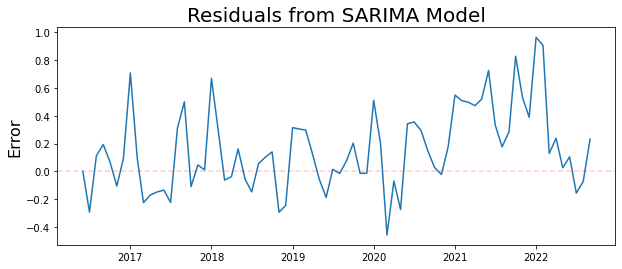

In [ ]:
SARIMA_roll_residuals = df.loc[end_time:] - SARIMA_roll_train.loc[end_time:]
plt.figure(figsize=(10,4))
plt.plot(SARIMA_roll_residuals)
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Error:', round(np.mean(abs(SARIMA_roll_residuals['CPI'])),4))
print('\nRoot Mean Squared Error:', np.sqrt(np.mean(SARIMA_roll_residuals**2)))

Mean Absolute Error: 0.2496

Root Mean Squared Error: CPI    0.333071
dtype: float64


In [ ]:
SARIMA_test.tail()

,CPI
timestamp,
2022-05-01,0.308169
2022-06-01,0.308169
2022-07-01,-0.011812
2022-08-01,-0.035440
2022-09-01,0.215078


# Forecasting

In [ ]:
#consider entire dataset as training data for estimating forecasts for next 6 months
start_time = datetime(1960,1,1)
end_time = datetime(2022,9,1)

In [ ]:
#obtain time series forecasts for the next 6 months
my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

roll_end_time = end_time
SARIMA_roll_train = df.loc[start_time:end_time]
c = 0
while c <= 5:
  SARIMA_roll_model = SARIMAX(SARIMA_roll_train, order=my_order, seasonal_order=my_seasonal_order)
  SARIMA_roll_model_fit = SARIMA_roll_model.fit()
  SARIMA_roll_predictions = SARIMA_roll_model_fit.predict(start = roll_end_time, end = roll_end_time+relativedelta(months=+0))

  print(roll_end_time)
  roll_end_time = roll_end_time + relativedelta(months=+1)
  SARIMA_roll_train.loc[roll_end_time] = float(SARIMA_roll_predictions)
  c += 1

2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00


In [ ]:
time = []
roll_end_time = end_time + relativedelta(months=+1)
for i in range(6):
  time.append(roll_end_time)
  roll_end_time = roll_end_time + relativedelta(months=+1)

Text(0, 0.5, 'CPI')

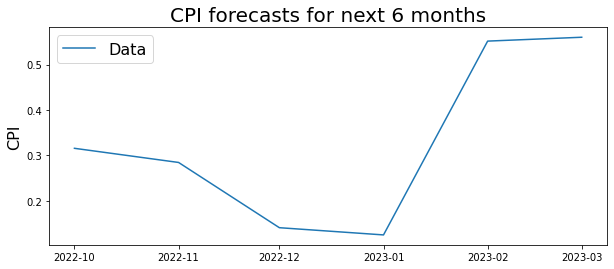

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(time, SARIMA_roll_train.loc[end_time+ relativedelta(months=+1):])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('CPI forecasts for next 6 months', fontsize=20)
plt.ylabel('CPI', fontsize=16)
# plt.savefig('forecasts.png')

In [ ]:
forecasts = list(SARIMA_roll_train.loc[end_time+ relativedelta(months=+1):]['CPI'])

In [ ]:
for i in range(6):
  forecasts[i] = round(forecasts[i],4)

In [ ]:
!pip install flask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 761 kB 4.2 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=cfa6075fdae4744fa5b7fba54f9c23cc4d91411d456fdd6a3c19b21f0d4f5c17
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok


In [ ]:
from flask import Flask
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok
from matplotlib.figure import Figure
import base64
from io import BytesIO
app = Flask(__name__)

ngrok.set_auth_token("2IpkBCiDA83xf2KrSJ3MwYS3Mgw_7Ue63kV6xvrZt2C2FVpJe")

run_with_ngrok(app)   
s = "<html><style> table, th, td {border:1px solid black;}</style><body>"
s += "<h2>Consumer Price Index forecasts for next 6 months</h2><table style='width:100%'><tr>"
s += "<th>Time</th><th>Consumer Price Index</th>"
s += "</tr> <tr> <td>"+str(time[0])[:10]+"</td><td>"+str(forecasts[0])+"</td>"
s += "</tr> <tr> <td>"+str(time[1])[:10]+"</td><td>"+str(forecasts[1])+"</td>"
s += "</tr> <tr> <td>"+str(time[2])[:10]+"</td><td>"+str(forecasts[2])+"</td>"
s += "</tr> <tr> <td>"+str(time[3])[:10]+"</td><td>"+str(forecasts[3])+"</td>"
s += "</tr> <tr> <td>"+str(time[4])[:10]+"</td><td>"+str(forecasts[4])+"</td>"
s += "</tr> <tr> <td>"+str(time[5])[:10]+"</td><td>"+str(forecasts[5])+"</td>"
s += "</table>"
# s += "<img src='/content/forecasts.png'>"
s += "</body></html>"

 
@app.route("/")
def home():
    return s 
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://936f-35-221-179-138.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [13/Dec/2022 00:32:51] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Dec/2022 00:32:51] "GET /favicon.ico HTTP/1.1" 404 -
